# LANL Notebook

Link to competition and dataset: https://www.kaggle.com/c/LANL-Earthquake-Prediction

Anaysis: https://www.kaggle.com/jsaguiar/seismic-data-exploration


## The Dataset
The training dataset has 2 columns (x, y), representing a single, continuous seismic signal.  x is the signal value, and y is the time-to-next-earthquake. The test data consists of segments of seismic signals (x values), and for each signal point in a segment, a time-to-next-earthquake (y) must be predicted by a machine learning model.

The dataset is large with over 600 million data points in the training signal (9 GB in csv format) and working with it will prove to be challenging (loading, visualizing, training models etc.).


## Useful Ideas

1. Downsampling to reduce dataset size:
> There are ways to do this without aliasing error (or minimal aliasing error). See the [Wiki article](https://en.wikipedia.org/wiki/Downsampling_(signal_processing)) (short).

2. Noise filtering and other signal enhancements:
> The signal *may* be noisy. Any good filters (especially those used in the seismic domain) will improve our model accuracy.

3. Feature engineering
The raw signal maybe 'too raw' for the RNN to learn useful/ predictive patterns. We may have to engineer features.

    3.1. Feature detecting filters
> Features in signals are usually detected by filters (a filter is defined by its kernel: the impulse response). There may be feature detecting filters already used in the seismic analysis domain. Eg: filters to detect the presence of a peak.

    3.2. Engineering other features
> We can engineering other features such as: does_peak_exist_in_this_window, time_since_last_peak, first_derivative, second_derivative, Fourier transform (DFT) of the window, etc.

4. Automating feature engineering via convolutional nets (CNN)
> CNNs essentially learn the kernels of filters as part of the neural network. We can have some CNN layers before the LSTM layers and see if that works.


In [1]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
#Data was convereted from CSV to HDF then truncated
hdf_key = 'my_key'

# Change the following to point to proper local paths
truncated_train_hdf_file = '../LANL-Earthquake-Prediction/truncated_train_hdf.h5' 
validation_hdf_file = '../LANL-Earthquake-Prediction/validation_hdf.h5'
test_hdf_file = '../LANL-Earthquake-Prediction/test_hdf.h5'


In [3]:
def read_hdf(filename, key):
    t0 = time.time()
    print('Reading HDF dataset {}'.format(filename))

    dataset_df = pd.read_hdf(filename, key=key)

    print('Reading complete. time_to_read={}'.format(filename, time.time() - t0))

    return dataset_df  # This is a Pandas DataFrame

In [4]:
def print_info(df):
    print("Dataset shape = {}".format(df.shape))
    df.info(memory_usage='deep')    # Some info about the dataset (memory usage etc.)

    pd.set_option("display.precision", 15)  # Show more decimals
    print(df.head())

    # print(df.acoustic_data.describe())  # Some stats; can take time if dataset is large


def truncate_dataset(df, num_rows_to_keep):
    print('Truncating the dataset. num_rows_to_keep={}'.format(num_rows_to_keep))
    trunc_df = df[:num_rows_to_keep]
    print('Truncating complete. trunc_df.shape={}'.format(trunc_df.shape))
    return trunc_df

In [5]:
def plot_series(df):
    print('Plotting series')
    # plt.plot(series)
    # plt.show()

    fig, ax1 = plt.subplots()

    color = 'tab:orange'
    ax1.set_xlabel('time (#points)')
    ax1.set_ylabel('seismic_signal', color=color)
    ax1.plot(df.acoustic_data, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('time_to_earthquake', color=color)  # we already handled the x-label with ax1
    ax2.plot(df.time_to_failure, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

## Import truncated Data from hdf files
### 3 sets: train, validation, test. Print basic stats about them and plot them

In [6]:
train_df = read_hdf(truncated_train_hdf_file, hdf_key)
valid_df = read_hdf(validation_hdf_file, hdf_key)
test_df = read_hdf(test_hdf_file, hdf_key)

Reading HDF dataset ../LANL-Earthquake-Prediction/truncated_train_hdf.h5
Reading ../LANL-Earthquake-Prediction/truncated_train_hdf.h5 complete. time_to_read=6.144085645675659
Reading HDF dataset ../LANL-Earthquake-Prediction/validation_hdf.h5
Reading ../LANL-Earthquake-Prediction/validation_hdf.h5 complete. time_to_read=3.396406650543213
Reading HDF dataset ../LANL-Earthquake-Prediction/test_hdf.h5
Reading ../LANL-Earthquake-Prediction/test_hdf.h5 complete. time_to_read=1.153538465499878


Dataset shape = (139000000, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 139000000 entries, 0 to 138999999
Data columns (total 2 columns):
acoustic_data      int16
time_to_failure    float64
dtypes: float64(1), int16(1)
memory usage: 2.3 GB
   acoustic_data  time_to_failure
0             12     1.4690999832
1              6     1.4690999821
2              8     1.4690999810
3              5     1.4690999799
4              8     1.4690999788
Plotting series


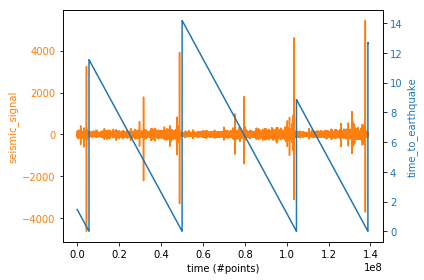

In [7]:
print_info(train_df)
plot_series(train_df) # This is time and memory consuming. Do not run this cell unless necessary

Dataset shape = (80000000, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80000000 entries, 139000000 to 218999999
Data columns (total 2 columns):
acoustic_data      int16
time_to_failure    float64
dtypes: float64(1), int16(1)
memory usage: 1.3 GB
           acoustic_data     time_to_failure
139000000              5  12.635497500000001
139000001              3  12.635497499000001
139000002              5  12.635497497999999
139000003             -2  12.635497497000001
139000004              0  12.635497495999999
Plotting series


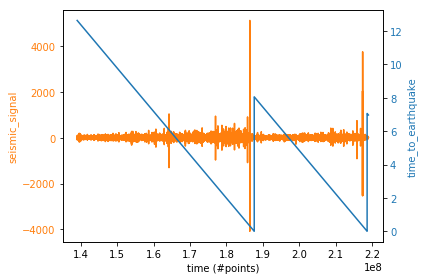

In [8]:
print_info(valid_df)
plot_series(valid_df) # This is time and memory consuming. Do not run this cell unless necessary

Dataset shape = (27000000, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27000000 entries, 219000000 to 245999999
Data columns (total 2 columns):
acoustic_data      int16
time_to_failure    float64
dtypes: float64(1), int16(1)
memory usage: 463.5 MB
           acoustic_data    time_to_failure
219000000              1  6.969696360400000
219000001             -1  6.969696359299999
219000002              0  6.969696358200000
219000003              3  6.969696357100000
219000004              6  6.969696356000000
Plotting series


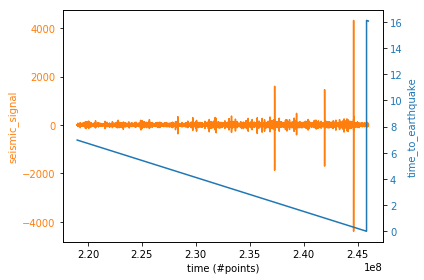

In [9]:
print_info(test_df)
plot_series(test_df) # This is time and memory consuming. Do not run this cell unless necessary

# Understanding Data

## Domain Perspective

We need to check physical relation between acoustic data data and earthquakes. Any equation available?!

## Statistical Perspective

https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424

We need to test data for random-walk/stochasiticity, e.g. correlation tests on both signal (f) and (df), covariance test?!



# Recurrent Neural Network - LSTM

## Part 1 - Data Preprocessing

In [7]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
# Importing the training set
dataset_train = train_df
training_set = dataset_train.iloc[:, 0:2].values

In [9]:
# Feature Scaling - Ignored for now
"""
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler (feature_range=(0, 1))
training_set_scaled = sc.fit_transform (training_set) 
"""
training_set_scaled = training_set

In [10]:
# Creating a data structure with 1000 timesteps and 1 output
X_train = []
y_train = []

"""
Temporary: we reduce the datatset by 400 to exceuste fast!
Temporary: 1000 (steps in the past) is picked randomly while it should be carefully studied
"""
    
for i in range (1000, int(train_df.shape[0]/400)): 
    X_train.append (training_set_scaled[i - 1000:i, 0])
    y_train.append (training_set_scaled[i, 1])
X_train, y_train = np.array (X_train), np.array (y_train)

# Reshaping
X_train = np.reshape (X_train, (X_train.shape[0], X_train.shape[1], 1))

## Part 2 - Building the RNN

In [11]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential ()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add (LSTM (units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add (Dropout (0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add (LSTM (units=50, return_sequences=True))
regressor.add (Dropout (0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add (LSTM (units=50, return_sequences=True))
regressor.add (Dropout (0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add (LSTM (units=50))
regressor.add (Dropout (0.2))

# Adding the output layer
regressor.add (Dense (units=1))

# Compiling the RNN
regressor.compile (optimizer='adam', loss='mean_squared_error')

Using TensorFlow backend.


## Part 3 - Training the RNN

In [ ]:
print('Training the RNN with the training set')
regressor.fit (X_train, y_train, epochs=100, batch_size=32)
print('Training complete')

Training the RNN with the training set
Epoch 1/100
   320/346500 [..............................] - ETA: 4:16:06 - loss: 0.7591

## Part 4 - Making the predictions and visualising the results

#### Samer, please add the code for predicting on the validation set